In [154]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from pprint import pprint
import xgboost as xgb
from numpy.random import seed
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error as mse
plt.style.use('dark_background')
SEED = 23

In [2]:
def Winsorization_Method(df_source, columns,  lower, upper):
    """
    Remove outliers from the given DataFrame based on the provided lower and upper percentiles.

    Parameters:
    -----------
    df_source : pandas.DataFrame
        The original DataFrame from which outliers will be removed.
    columns : list of str
        The names of the columns to consider for outlier removal.
    lower : float
        The lower percentile below which data points are considered as outliers.
    upper : float
        The upper percentile above which data points are considered as outliers.

    Returns:
    --------
    ratio : float
        The ratio of outliers in the original DataFrame, rounded to two decimal places.
    df_win : pandas.DataFrame
        A new DataFrame with the outliers removed.
    
    Example:
    --------
    >>> ratio, df_win = Winsorization_Method(df, ['A', 'B'], 10, 90)
    
    Notes:
    ------
    - The function makes a copy of the original DataFrame, so the original DataFrame remains unchanged.
    - Outliers are determined separately for each column and are not considered across multiple columns.

    """
    #Data preparation
    df = df_source.copy()
    df = df[columns]

    #Determining records with outliers
    outliers=[]
    
    for col in columns:
        q1 = np.percentile(df[col], lower)
        q2 = np.percentile(df[col], upper)
        
        for pos in range(len(df)):
            if df[col].iloc[pos]>q2 or df[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers = set(outliers)                   
    outliers = list(outliers)
    
    ratio= round(len(outliers)/len(df)*100, 2) #calculating the ratio of outliers in the original data                     
    df_win = df.drop(df.index[outliers]) 
    
    print('Ratio of outliers in original dataset: ', ratio)
    return df_win

In [3]:
def Standard_Outlier_Remover(df_source, num_cols, num_std=3): 
    """
    Remove outliers from specified numeric columns in a DataFrame.
    
    Parameters:
    -----------
    df_source : pandas DataFrame
        The original DataFrame from which to remove outliers.
    num_cols : list of str
        List of column names in df_source that are numeric and should be checked for outliers.
    num_std : int or float, optional
        The number of standard deviations to use for defining outliers. Default is 3.
        
    Returns:
    --------
    df_win : pandas DataFrame
        A new DataFrame with outliers removed.
    ratio : float
        The percentage of observations in the original DataFrame that were identified as outliers.
    outliers : list of int
        List of row indices in the original DataFrame that were identified as outliers.
    """
    
    df = df_source.copy()
    
    outliers = []
    
    for col in num_cols:
        mean = df[col].mean()
        std = df[col].std()
        tol = num_std * std
        upper = mean + tol
        lower = mean - tol
        
        # Using vectorized operations to find outliers
        outlier_mask = (df[col] > upper) | (df[col] < lower)
        outliers.extend(df.index[outlier_mask])
        
    # Remove duplicates
    outliers = list(set(outliers))
    
    # Calculate ratio of outliers
    ratio = round(len(outliers) / len(df) * 100, 2)
    
    # Drop outliers
    df_win = df.drop(index=outliers)
    
    print('Ratio of outliers in original dataset: ', ratio)
    return df_win, outliers

## Data scrapping

In [ ]:
import requests 
from bs4 import BeautifulSoup 
from selenium import webdriver
import time
import yfinance as yf
import missingno as mno


#List of SP500 companies
wikiurl="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response=requests.get(wikiurl)

soup = BeautifulSoup(response.text, 'html.parser')
sp500=soup.find('table',{'class':"wikitable"})
sp500=pd.read_html(str(sp500))
sp500=pd.DataFrame(sp500[0])
names = sp500['Symbol']
sp500.to_csv('D:/UW/Master/data/sp500.csv')

#price, volume
price = pd.DataFrame()
count = 0

for name in names.str.replace('.','-'):
    tickerData = yf.Ticker(name)
    tickerDf = tickerData.history(period='max')
    tickerDf['COMPANY'] = name
    tickerDf['SECTOR'] = sp500.loc[count, 'GICS Sector']
    price = price.append(tickerDf)
    count += 1
    print(count, str(name)+' is done. Total number: ', len(price))
    
price_sum = price[['COMPANY', 'SECTOR', 'Close']]
price_sum = price_sum.dropna()
price_sum['QUARTER'] = pd.PeriodIndex(price_sum.index, freq='Q')
price_sum = price_sum.groupby(['COMPANY','SECTOR','QUARTER'])['Close'].median()
price_sum = price_sum.reset_index()

#dividends
divd = price[['COMPANY', 'SECTOR', 'Dividends', 'Volume']]
divd = divd.dropna()
divd['QUARTER'] = pd.PeriodIndex(divd.index, freq='Q')
divd = divd.groupby(['COMPANY','SECTOR','QUARTER'])['Dividends', 'Volume'].sum()
divd = divd.reset_index()

result0 = pd.merge(divd, price_sum, on=["COMPANY", "QUARTER", 'SECTOR'])
result0 = result0.reset_index()
result0.drop('index', axis = 1, inplace = True)


#other variables
df = pd.DataFrame()
variables = ['revenue','shares-outstanding', 'net-income', 'total-assets', 'total-liabilities', 'cash-on-hand', 'total-share-holder-equity', 'number-of-employees']
headers = {
    'Accept-Encoding': 'gzip, deflate, sdch',
    'Accept-Language': 'en-US,en;q=0.8',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
}
for var in variables:
    count = 0
    print(var)
    for name in names.str.replace('-','.'):
        url = "https://www.macrotrends.net/stocks/charts/"+str(name)+"/apple/"+str(var)
        try:
            response=requests.get(url, headers=headers)
            soup = BeautifulSoup(response.text, 'html.parser')
            value = soup.find_all('table',{'class':"table"})
            value = pd.read_html(str(value))
            value = pd.DataFrame(value[1])
            value.columns = ['Date', 'Amount']
            value['Variable'] = var
            value['COMPANY'] = name
            value['SECTOR'] = sp500.loc[count, 'GICS Sector']
            df = df.append(value)
            value = None
        except:
            pass
        print(count, str(name)+' is done. Total number of records: ', len(df))
        count += 1
df.to_csv('D:/UW/Master/data/df.csv') 

df_wide = df.copy()
df_wide['Amount'] = df_wide['Amount'].str.strip('$').str.replace(',', '')
df_wide['Amount'] = df_wide['Amount'].astype('float')
df_wide['Date'] = pd.to_datetime(df_wide['Date'], format = '%Y/%m/%d')
df_wide['QUARTER'] = pd.PeriodIndex(df_wide['Date'], freq='Q')
df_wide = df_wide.pivot_table(index=['Date', 'QUARTER', 'COMPANY', 'SECTOR'], columns='Variable', values=['Amount'], aggfunc='first')
df_wide = df_wide.droplevel(0, axis = 1)

result = pd.merge(df_wide, result0, on=["COMPANY", "QUARTER", 'SECTOR'])
mno.matrix(result, figsize = (20, 6))
result.isna().sum()
result = result.dropna()

In [116]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'AAPL'  # Example for Apple

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2021-1-1')

# Display data
print(tickerDf)


                  Open        High         Low       Close     Volume   
Date                                                                    
2009-12-31    6.452355    6.459016    6.374550    6.379696  352410800  \
2010-01-04    6.461438    6.493832    6.429650    6.478997  493729600   
2010-01-05    6.496861    6.526832    6.455990    6.490201  601904800   
2010-01-06    6.490200    6.515933    6.380304    6.386964  552160000   
2010-01-07    6.410578    6.418146    6.328837    6.375156  477131200   
...                ...         ...         ...         ...        ...   
2020-12-24  129.041004  131.143865  128.824821  129.679718   54930100   
2020-12-28  131.664670  134.956524  131.192990  134.317810  124486200   
2020-12-29  135.654240  136.381388  132.008618  132.529419  121047300   
2020-12-30  133.227074  133.629962  131.084899  131.399353   96452100   
2020-12-31  131.753099  132.401648  129.434055  130.387222   99116600   

            Dividends  Stock Splits  
Date        

## Data preparation

In [4]:
data = pd.read_csv('D:/UW/Master/data/result.csv')

data = data.loc[data['QUARTER'].isin(['2019Q1', '2019Q2', '2019Q3', '2019Q4',
                                     '2020Q1', '2020Q2', '2020Q3', '2020Q4',
                                     '2021Q1', '20121Q2','2021Q3', '2021Q4'])]
data.shape

(5422, 26)

In [5]:
data.columns = ['Unnamed: 0', 'QUARTER', 'COMPANY', 'cash-on-hand', 'net-income',
       'number-of-employees', 'revenue', 'shares-outstanding', 'total-assets',
       'total-liabilities', 'total-share-holder-equity', 'Close', 'Range',
       'Dividends', 'Volume', 'Security', 'SEC filings', 'SECTOR',
       'GICS Sub-Industry', 'Headquarters Location', 'Date first added', 'CIK',
       'Founded', 'market_cap', 'dividends_sum', 'dividend_yield']

In [6]:
cols = ['QUARTER', 'SECTOR', 'cash-on-hand', 'net-income', 'revenue',
       'total-assets', 'total-liabilities', 'total-share-holder-equity',
       'Volume', 'Dividends', 'Close']
data = data[cols]
#data = data.sample(frac=1)
data.head()

,QUARTER,SECTOR,cash-on-hand,net-income,revenue,total-assets,total-liabilities,total-share-holder-equity,Volume,Dividends,Close
40,2019Q1,Health Care,2057.0,504.0,1284.0,8952.0,3916.0,5036.0,112942800,0.000,64.952698
41,2019Q2,Health Care,2155.0,182.0,1238.0,9022.0,3897.0,5125.0,160069900,0.000,79.076245
42,2019Q3,Health Care,1765.0,191.0,1274.0,8625.0,3878.0,4747.0,168991000,0.164,73.991930
43,2019Q4,Health Care,1382.0,194.0,1367.0,9452.0,4704.0,4748.0,101569300,0.180,75.199045
44,2020Q1,Health Care,1226.0,197.0,1357.0,9501.0,4653.0,4848.0,153386800,0.180,84.617499


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5422 entries, 40 to 24678
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   QUARTER                    5422 non-null   object 
 1   SECTOR                     5422 non-null   object 
 2   cash-on-hand               5200 non-null   float64
 3   net-income                 5421 non-null   float64
 4   revenue                    5421 non-null   float64
 5   total-assets               5210 non-null   float64
 6   total-liabilities          5210 non-null   float64
 7   total-share-holder-equity  5210 non-null   float64
 8   Volume                     5422 non-null   int64  
 9   Dividends                  5422 non-null   float64
 10  Close                      5422 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 508.3+ KB


In [8]:
data.dropna(inplace=True)

In [9]:
data.describe()

,cash-on-hand,net-income,revenue,total-assets,total-liabilities,total-share-holder-equity,Volume,Dividends,Close
count,5.199000e+03,5199.000000,5199.000000,5.199000e+03,5.199000e+03,5199.000000,5.199000e+03,5199.000000,5199.000000
mean,1.341850e+04,620.557223,6399.846894,7.630506e+04,6.006305e+04,16241.909983,3.040823e+08,0.427844,141.403002
std,8.163936e+04,1873.469465,12560.186713,2.440187e+05,2.200836e+05,31878.934348,6.310031e+08,0.783476,258.795205
min,2.000000e+00,-20070.000000,-872.000000,3.190000e+02,1.170000e+02,-18075.000000,4.573000e+05,0.000000,3.145847
25%,5.120000e+02,101.000000,1150.500000,9.412000e+03,5.590000e+03,2895.500000,6.822060e+07,0.000000,46.863980
50%,1.426000e+03,246.000000,2503.000000,2.116700e+04,1.406900e+04,6643.000000,1.308452e+08,0.320000,84.580876
75%,4.116000e+03,627.500000,5462.000000,5.434200e+04,3.826650e+04,15248.000000,2.882345e+08,0.610000,152.430730
max,1.557931e+06,34630.000000,152079.000000,3.757576e+06,3.467535e+06,290041.000000,1.223372e+10,32.500000,4962.310059


C:\Users\Pavilion\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


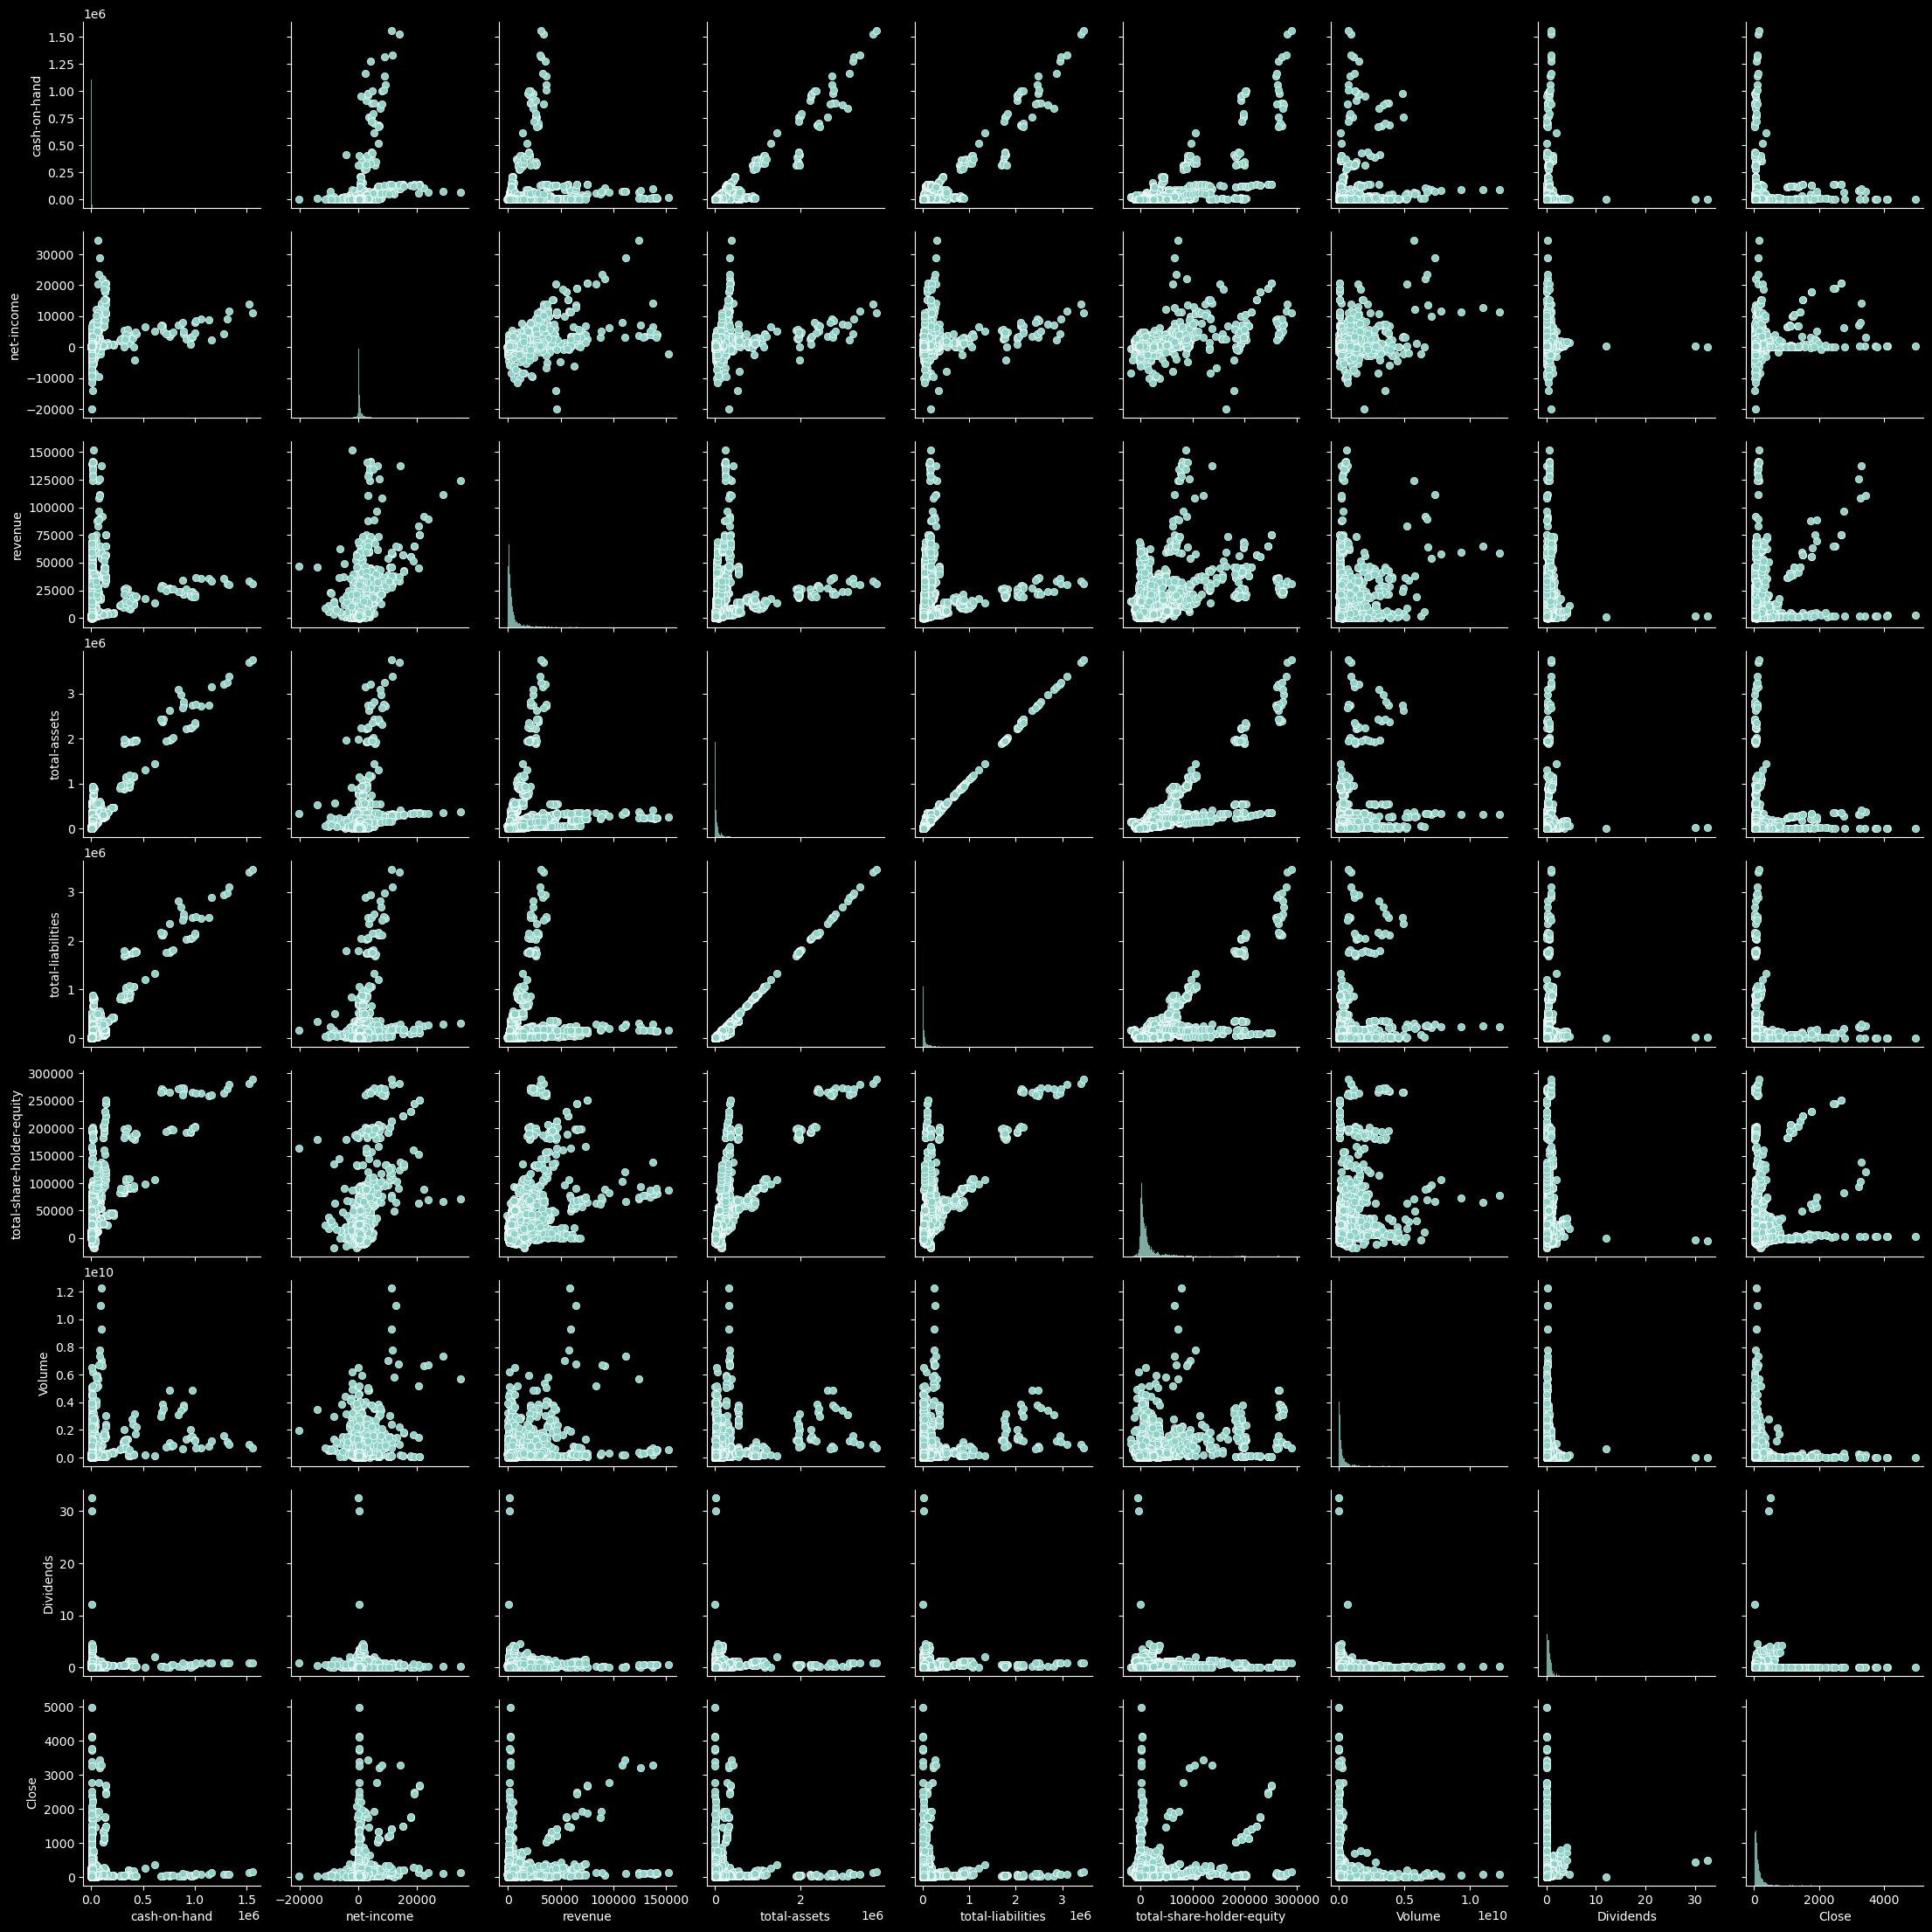

In [10]:
sns.pairplot(data)

In [11]:
df_std, std_outliers = Standard_Outlier_Remover(data, data.select_dtypes(include='number').columns, num_std=3)

Ratio of outliers in original dataset:  6.96


C:\Users\Pavilion\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


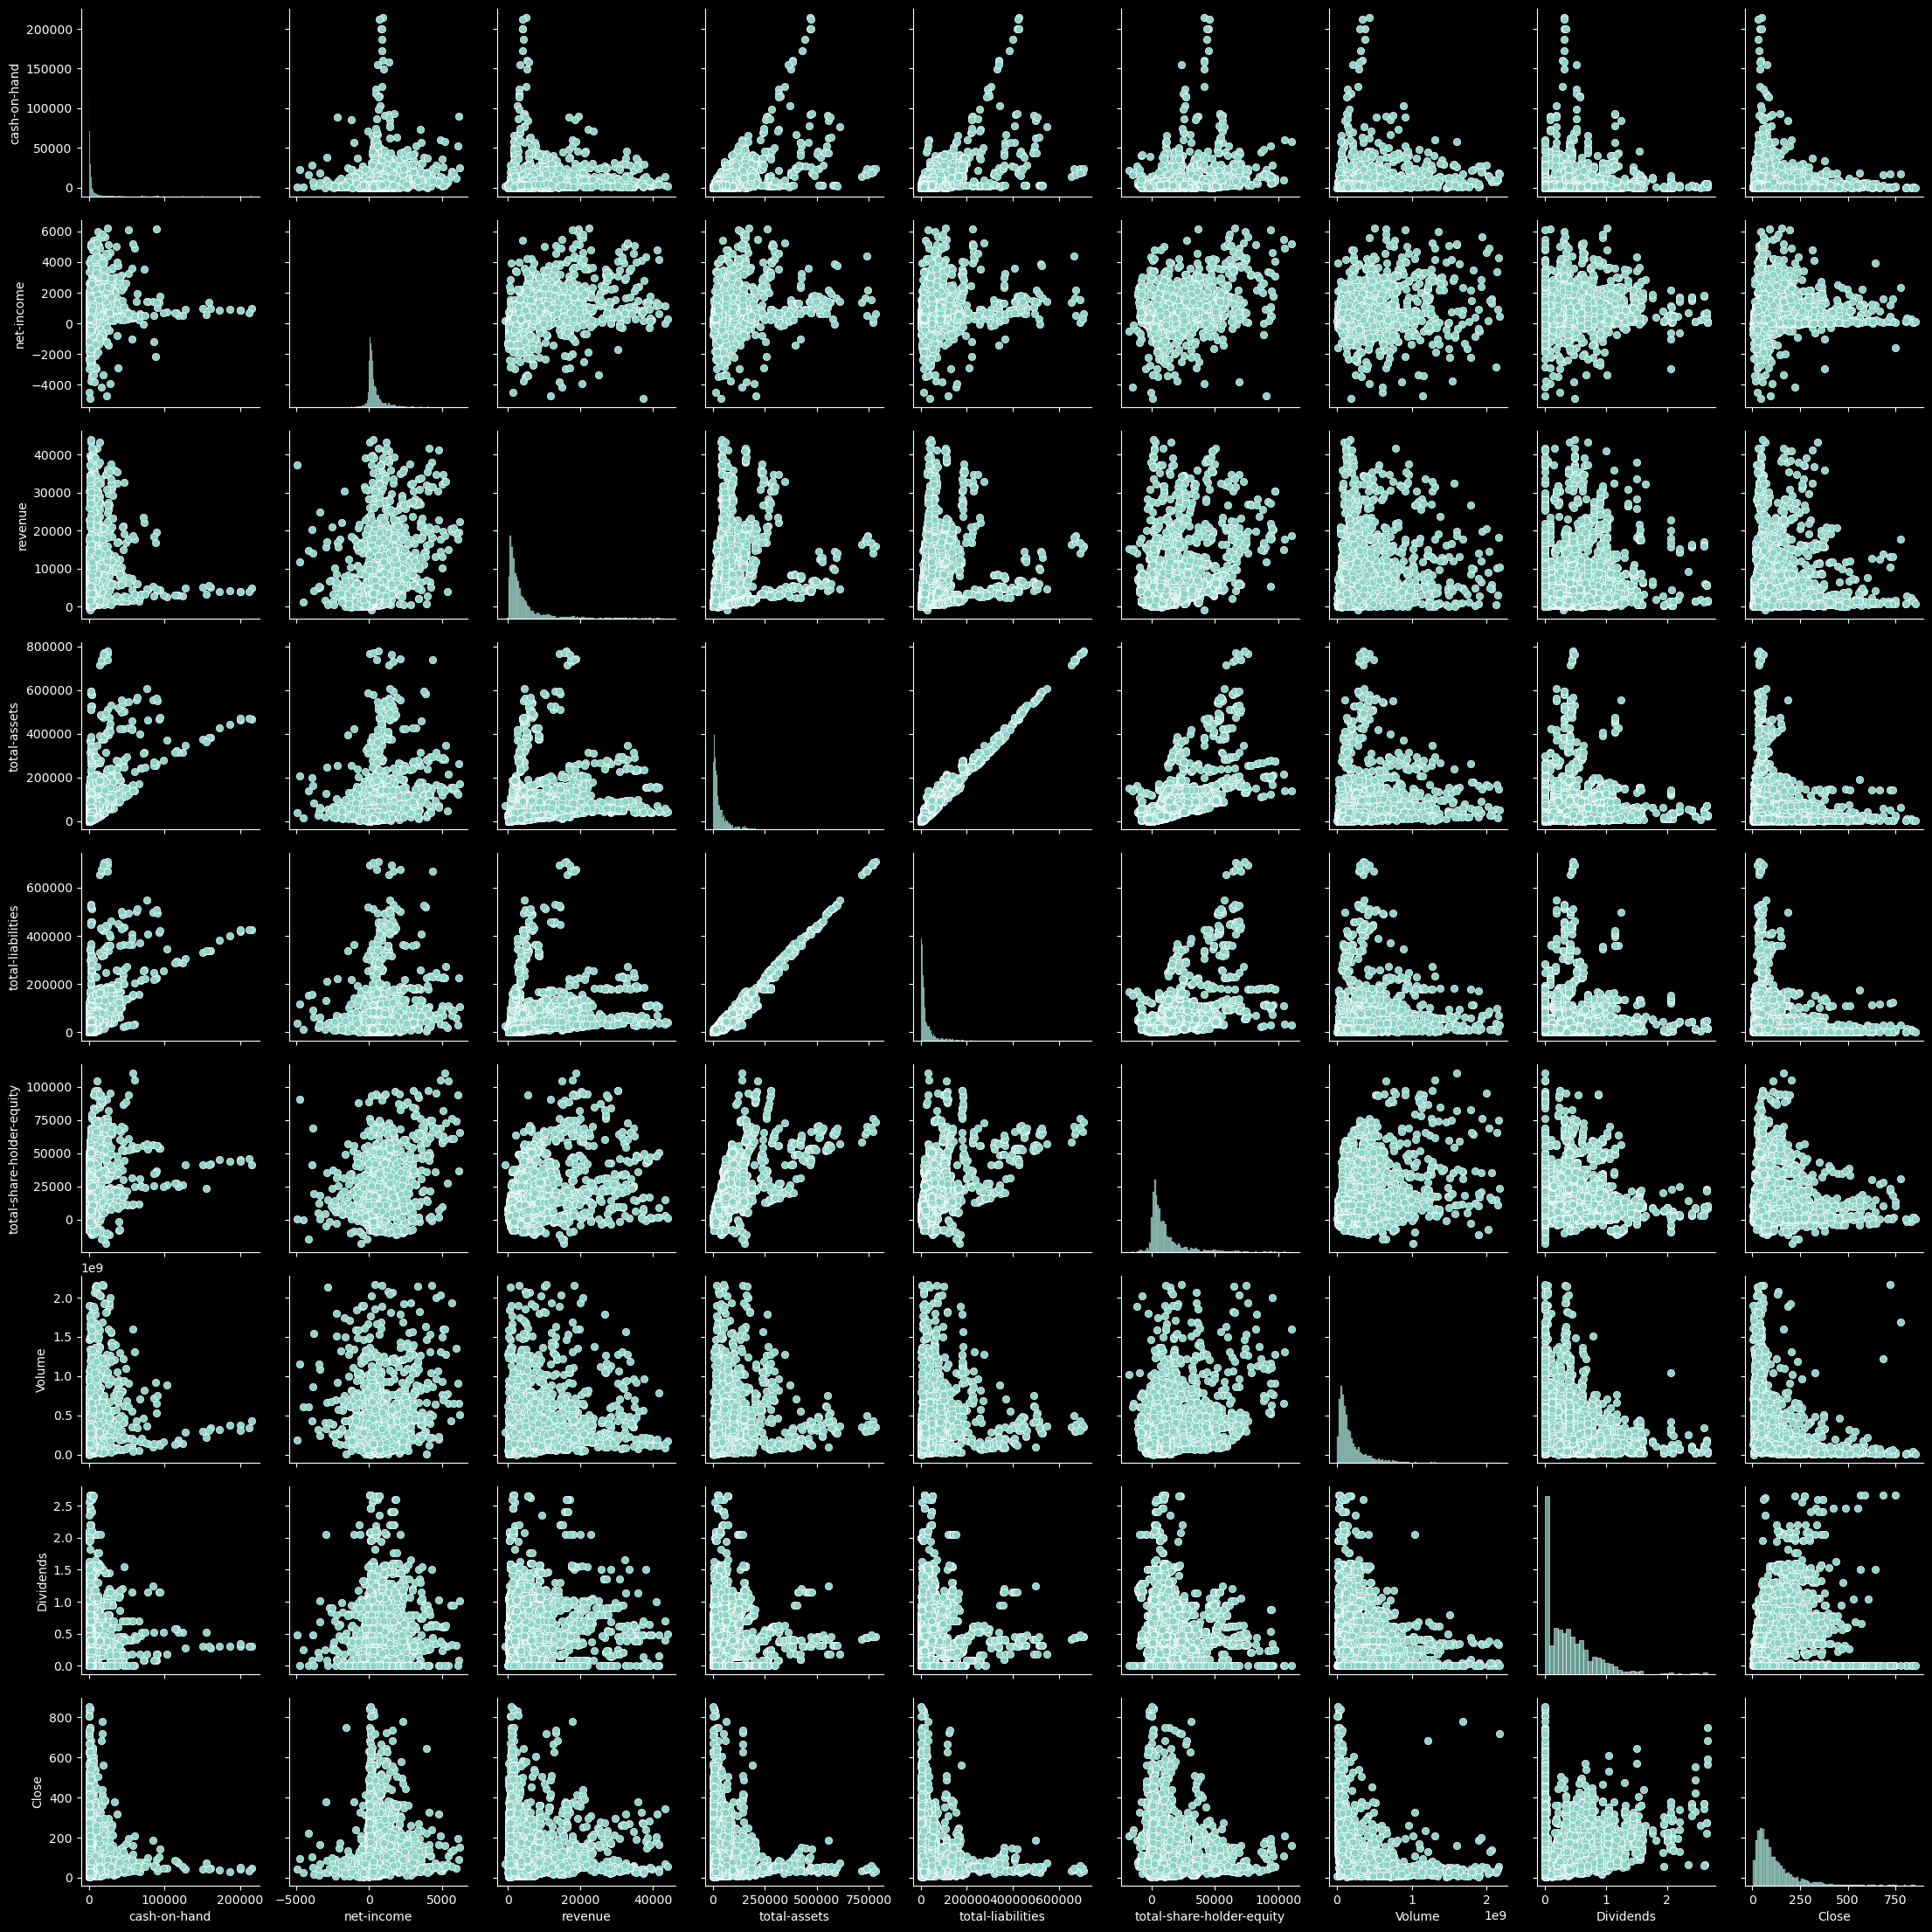

In [12]:
sns.pairplot(df_std)

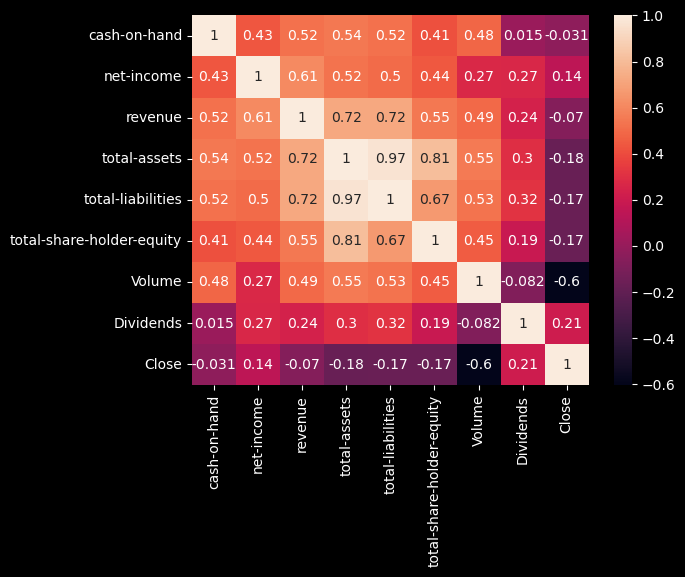

In [13]:
num_df = pd.DataFrame(df_std.select_dtypes(include='number'))
corrMatrix = num_df.corr(method = 'spearman')
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [14]:
num_df_corr = num_df.drop(['total-assets'], axis = 1)

In [15]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_std.select_dtypes(include='object'))
one_hot.reset_index(inplace = True)
one_hot.drop('index', axis =1, inplace = True)
one_hot.tail()

,QUARTER_2019Q1,QUARTER_2019Q2,QUARTER_2019Q3,QUARTER_2019Q4,QUARTER_2020Q1,QUARTER_2020Q2,QUARTER_2020Q3,QUARTER_2020Q4,QUARTER_2021Q1,QUARTER_2021Q3,...,SECTOR_Consumer Discretionary,SECTOR_Consumer Staples,SECTOR_Energy,SECTOR_Financials,SECTOR_Health Care,SECTOR_Industrials,SECTOR_Information Technology,SECTOR_Materials,SECTOR_Real Estate,SECTOR_Utilities
4832,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
4833,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4834,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
4835,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4836,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False


In [16]:
one_hot.columns

Index(['QUARTER_2019Q1', 'QUARTER_2019Q2', 'QUARTER_2019Q3', 'QUARTER_2019Q4',
       'QUARTER_2020Q1', 'QUARTER_2020Q2', 'QUARTER_2020Q3', 'QUARTER_2020Q4',
       'QUARTER_2021Q1', 'QUARTER_2021Q3', 'QUARTER_2021Q4',
       'SECTOR_Communication Services', 'SECTOR_Consumer Discretionary',
       'SECTOR_Consumer Staples', 'SECTOR_Energy', 'SECTOR_Financials',
       'SECTOR_Health Care', 'SECTOR_Industrials',
       'SECTOR_Information Technology', 'SECTOR_Materials',
       'SECTOR_Real Estate', 'SECTOR_Utilities'],
      dtype='object')

In [17]:
df = num_df_corr.join(one_hot)
df.tail()

,cash-on-hand,net-income,revenue,total-liabilities,total-share-holder-equity,Volume,Dividends,Close,QUARTER_2019Q1,QUARTER_2019Q2,...,SECTOR_Consumer Discretionary,SECTOR_Consumer Staples,SECTOR_Energy,SECTOR_Financials,SECTOR_Health Care,SECTOR_Industrials,SECTOR_Information Technology,SECTOR_Materials,SECTOR_Real Estate,SECTOR_Utilities
24672,1799.0,251.0,3493.0,14105.0,-3395.0,115645400,0.20,61.767748,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24673,1725.0,308.0,3408.0,13856.0,-3351.0,162695100,0.20,66.565519,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24675,1553.0,331.0,3620.0,13767.0,-3295.0,136722000,0.24,81.493388,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24676,3475.0,281.0,3569.0,15423.0,-3144.0,132535500,0.24,82.177341,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24677,1008.0,323.0,1600.0,12953.0,-1618.0,137277600,0.00,30.110001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
X, y = df.drop('Close', axis=1), df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [66]:
X_train.shape, X_test.shape

((3869, 29), (968, 29))

## XGBoost

In [67]:
float_cols = X.select_dtypes('float').columns
int_cols = X.select_dtypes('int').columns
obj_cols = X.select_dtypes('object').columns

for col in float_cols:
    X_train[col] = X_train[col].astype('float32')
    X_test[col] = X_test[col].astype('float32')
    
for col in int_cols:
    X_train[col] = X_train[col].astype('int32')
    X_test[col] = X_test[col].astype('int32')                                
    
for col in obj_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

y_train, y_test = y_train.astype('float32'),  y_test.astype('float32')

In [69]:
dtrain = xgb.DMatrix(X_train, label = y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label = y_test, enable_categorical=True)

In [43]:
params = {"objective":"reg:squarederror", "booster":"gbtree"}
cv_results = xgb.cv(dtrain=dtrain, 
                    params=params, 
                    nfold=5, 
                    num_boost_round=50,
                    early_stopping_rounds=10,
                    metrics="mape", 
                    as_pandas=True, 
                    seed=SEED)

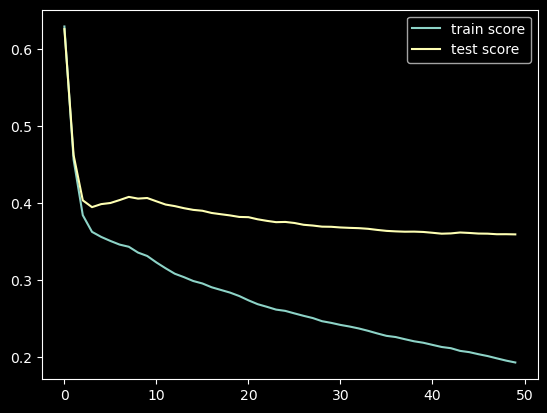

In [105]:
plt.plot(cv_results.iloc[:,0])
plt.plot(cv_results.iloc[:,2])
plt.legend(['train score', 'test score'])

In [71]:
xgb_reg = xgb.train(params, dtrain, num_boost_round=50)

In [90]:
importance = xgb_reg.get_score(importance_type='weight')

In [91]:
# Aggregate the importances for one-hot encoded features
original_feature_importance = {}
for feature, importance in importance.items():
    original_feature = feature.split('_')[0]  
    if original_feature in original_feature_importance:
        original_feature_importance[original_feature] += importance
    else:
        original_feature_importance[original_feature] = importance

# Sort and display the aggregated feature importances
sorted_importance = sorted(original_feature_importance.items(), key=lambda x: x[1], reverse=True)
agg_importance_df = pd.DataFrame(sorted_importance, columns = ['Feature', 'F score'])

<Axes: ylabel='Feature'>

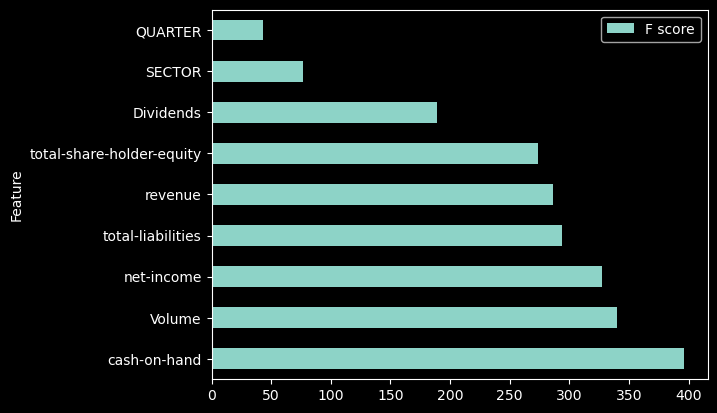

In [104]:
agg_importance_df.set_index('Feature').plot.barh()

In [148]:
param_grid = {
    'max_depth': range(3, 10),
    'eta': np.arange(0.1,0.9,0.1),
    'subsample': np.arange(0.1,1,0.1),
    'colsample_bytree': np.arange(0.1,1,0.1),
}

In [ ]:
def cross_val_score_xgb(params, dtrain, num_boost_round=50, nfold=3, metrics = 'rmse'):
    cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, nfold=nfold, metrics = metrics)
    return np.mean(cv_results['test-rmse-mean'])

In [158]:
# Define a broad parameter grid
param_grid = {
    'max_depth': range(3, 10),
    'eta': np.arange(0.01, 0.99, 0.01),
    'subsample': np.arange(0.50, 0.99, 0.01),
    'colsample_bytree': np.arange(0.50, 0.99, 0.01)
}

# Define the number of random combinations to try
num_combinations = 50

# Conduct Random Search
best_score = float('inf')
best_params = None

for _ in range(num_combinations):
    random_params = {k: random.choice(v) for k, v in param_grid.items()}
    score = cross_val_score_xgb(random_params, dtrain, num_boost_round=100, nfold=3)
    if score < best_score:
        best_score = score
        best_params = random_params

# Output the best parameters from Random Search
print(f"Best parameters from Random Search: {best_params}")
print(f"Best score from Random Search: {best_score}")

Best parameters from Random Search: {'max_depth': 8, 'eta': 0.32, 'subsample': 0.5900000000000001, 'colsample_bytree': 0.8400000000000003}
Best score from Random Search: 56.61451274372601


In [164]:
def calculate_variations(value, var_1lvl=0.05, var_2lvl=0.1):
    if isinstance(value, int):
        variation_1lvl = 1
        variation_2lvl = 2
        return [max(1, value - variation_2lvl), max(1, value - variation_1lvl), 
                value, 
                value + variation_1lvl, value + variation_2lvl]
    else:
        variation_1lvl = value * var_1lvl
        variation_2lvl = value * var_2lvl
        return [value - variation_1lvl, value - variation_2lvl, 
                value, 
                value + variation_1lvl, value + variation_2lvl]


In [165]:
new_param_grid = {param: calculate_variations(value) for param, value in best_params.items()}
new_param_grid

{'max_depth': [6, 7, 8, 9, 10],
 'eta': [0.304, 0.28800000000000003, 0.32, 0.336, 0.352],
 'subsample': [0.5605000000000001,
  0.531,
  0.5900000000000001,
  0.6195,
  0.6490000000000001],
 'colsample_bytree': [0.7980000000000003,
  0.7560000000000002,
  0.8400000000000003,
  0.8820000000000003,
  0.9240000000000004]}

In [167]:
best_score = float('inf')
best_params = None

for max_depth in new_param_grid['max_depth']:
    for eta in new_param_grid['eta']:
        for subsample in new_param_grid['subsample']:
            for colsample_bytree in new_param_grid['colsample_bytree']:
                params = {
                    'max_depth': max_depth,
                    'eta': eta,
                    'subsample': subsample,
                    'colsample_bytree': colsample_bytree,
                    'objective':'reg:squarederror', 
                    'booster':'gbtree',
                    'tree_method': 'gpu_hist'
                }
                score = cross_val_score_xgb(params, dtrain, num_boost_round=100, nfold=3)
                if score < best_score:
                    best_score = score
                    best_params = params

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

KeyboardInterrupt: 

## Random forest

In [433]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [None, 10, 30, 50],
    'max_features': [None, 2, 3, 4],
    'min_samples_leaf': [None, 2, 4, 6],
    'n_estimators': [100, 300, 600, 1000]
}
# Create a based model
rf = RandomForestRegressor(random_state = 42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [434]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:  8.8min finished


{'bootstrap': True,
 'max_depth': 30,
 'max_features': None,
 'min_samples_leaf': 2,
 'n_estimators': 1000}

In [455]:
rf = RandomForestRegressor(bootstrap = True, n_estimators = 1000, min_samples_leaf = 2, max_depth = 30,
                           random_state = 42)
rf.fit(X_train,y_train)
predictions = rf.predict(X_test)
rmse2 = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE for RandomForest: %f" % (rmse2))

RMSE for RandomForest: 0.021977


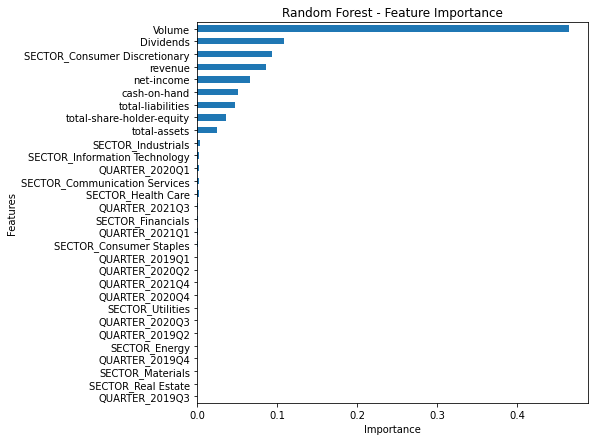

In [436]:
fea_imp = pd.DataFrame({'imp': rf.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(7, 7), legend=None)
plt.title('Random Forest - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

## Neural network

In [437]:
n_col = X_train.shape[1]

In [ ]:
rmse_list = []
for n1 in [n_col, n_col*2, n_col*4]:
    for n2 in [n_col, n_col*2, n_col*4]:
        for batch in [4, 8, 16, 32, 64]:
            seed(321)
            tensorflow.random.set_seed(123)
            model = Sequential()
            model.add(Dense(n1, input_dim=n_col,  activation='relu'))
            model.add(Dense(n2,  activation='relu'))
            model.add(Dense(1))
            model.compile(loss='mean_squared_error', optimizer='adam', 
                          metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])
            print(n1,n2,batch)
            callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_rmse', patience=10)
            history = model.fit(X_train, y_train, epochs=100, batch_size=batch, verbose=0, validation_data=(X_test, y_test), 
                                callbacks=[callback])
            rmse_list.append([n1, n2, batch, np.mean(history.history['val_rmse'])])

In [459]:
grid = pd.DataFrame(rmse_list, columns = ['n1', 'n2',  'batch', 'rmse'])
grid.sort_values('rmse').head()

,n1,n2,batch,rmse
17,60,30,16,0.032262
42,120,120,16,0.032812
40,120,120,4,0.033086
22,60,60,16,0.033101
1,30,30,8,0.033135


In [469]:
seed(321)
tensorflow.random.set_seed(321)
# create model
model = Sequential()
model.add(Dense(60, input_dim=n_col,  activation='relu'))
model.add(Dense(30,  activation='relu'))
model.add(Dense(1))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])

In [ ]:
seed(321)
tensorflow.random.set_seed(321)
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_rmse', patience=20)
history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0, validation_data=(X_test, y_test), 
                    callbacks=[callback])

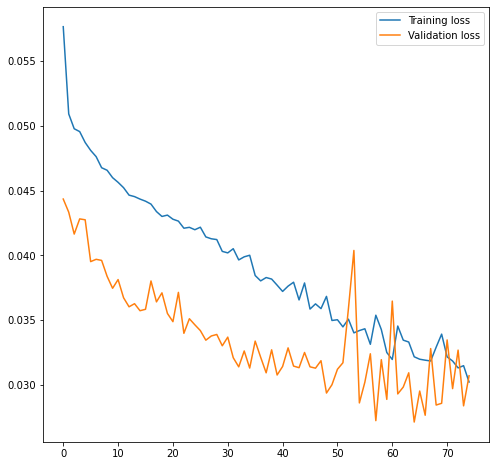

In [471]:
plt.plot(history.history['rmse'], label='Training loss')
plt.plot(history.history['val_rmse'], label='Validation loss')
plt.legend()

In [472]:
rmse3 = np.mean(history.history['val_rmse'])
rmse3

0.033692672128478686

## Combined Neural Network

In [549]:
combined = pd.DataFrame({'xgb': preds, 'rf':predictions, 'true': y_test})

In [550]:
combined

,xgb,rf,true
4039,0.011835,0.018757,0.009607
4040,-0.000726,0.001590,0.000671
4041,0.012736,0.014631,0.018597
4042,0.033476,0.027058,0.027554
4043,0.034123,0.034212,0.039463
...,...,...,...
5044,0.006442,0.012936,0.004069
5045,0.017546,0.015357,0.009155
5046,0.014940,0.021223,0.007250
5047,0.009185,0.006225,0.001096


In [445]:
n_col2 = combined.shape[1]

In [ ]:
rmse_list2 = []
for n1 in [n_col2, n_col2*2, n_col2*4]:
    for n2 in [n_col2, n_col2*2, n_col2*4]:
        for batch in [4, 8, 16, 32, 64]:
            seed(321)
            tensorflow.random.set_seed(123)
            print(n1,n2,batch)
            model2 = Sequential()
            model2.add(Dense(n1, input_dim=n_col2,  activation='relu'))
            model2.add(Dense(n2, input_dim=n_col2,  activation='relu'))
            model2.add(Dense(1))
            model2.compile(loss='mean_squared_error', optimizer='adam', 
                           metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])
            callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_rmse', patience=10)
            history2 = model2.fit(combined, y_test, epochs=100, batch_size=batch, verbose=0, validation_split=0.3, 
                                  callbacks=[callback])
            rmse_list2.append([n1, n2, batch, np.mean(history2.history['val_rmse'])])

In [475]:
grid2 = pd.DataFrame(rmse_list2, columns = ['n1', 'n2',  'batch', 'rmse'])
grid2.sort_values('rmse').head()

,n1,n2,batch,rmse
26,4,8,8,0.021302
25,4,8,4,0.021325
28,4,8,32,0.021915
27,4,8,16,0.022096
30,8,2,4,0.023231


In [536]:
seed(321)
model2 = Sequential()
model2.add(Dense(4, input_dim=n_col2,  activation='tanh'))
model2.add(Dense(8, input_dim=n_col2,  activation='tanh'))
model2.add(Dense(1))
# Compile model
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])

In [ ]:
seed(321)
history2 = model2.fit(combined, y_test, epochs=100, batch_size=16, verbose=0, validation_split=0.3, callbacks=[callback])

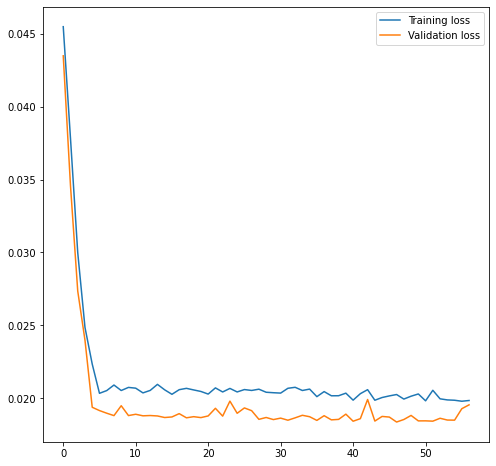

In [538]:
plt.plot(history2.history['rmse'], label='Training loss')
plt.plot(history2.history['val_rmse'], label='Validation loss')
plt.legend()

In [539]:
rmse4 = np.mean(history2.history['val_rmse'])
rmse4

0.019765711275109073

In [540]:
total_score = []
total_score.append(rmse)
total_score.append(rmse2)
total_score.append(rmse3)
total_score.append(rmse4)

In [541]:
df_total = pd.DataFrame(total_score, ['XGBoost', 'Random Forest',  'MLP', 'Combined MLP'], columns = ['RMSE'])
df_total.sort_values('RMSE')

,RMSE
XGBoost,0.017937
Combined MLP,0.019766
Random Forest,0.021977
MLP,0.033693


Text(0.5, 1.0, 'Root mean squarred error for different algorithms')

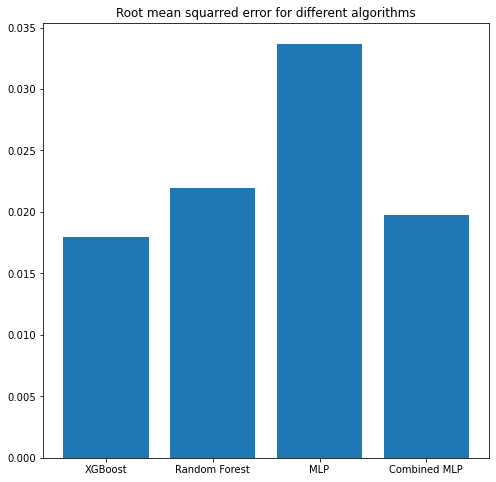

In [542]:
plt.bar(df_total.index, df_total.RMSE)
plt.title('Root mean squarred error for different algorithms')

## Summary

During analysis folowing models was used to predict Closing stock price of SP500 companies:
* XGboost
* Random Forest
* MLP neural network
* MLP neurlal network with input from XGBoost and Random Forest


With data and parameters mentioned in current project the best choise is XGboost. MLP neurlal network with input from XGBoost and Random Forest seems to suffer from little bias from Random Forest model - which RMSE is slightly higher. Common MLP model was the worst in my case. As an futher improvement some additional work can be done, for example, working with outliers and data pre-processing and better work with models tuning. 